In [1]:
include("optim_lib.jl")
include("lib_func.jl")

# Constants and Parameters
d1, d2, ds = 3, 10, 1  # Degree range and step
const n, a, b = 2, 5, 1 
const C = a / b  # Scaling constant, C is appears in `main_computation`, maybe it should be a parameter.
const delta, alph = .5 , 9 / 10  # Sampling parameters
f = camel # Objective function

camel (generic function with 1 method)

In [3]:
coeffs_poly_approx = main_gen(f, n, d1, d2, ds, delta, alph, C, 0.1)
coeffs_poly_precis = precise_gen(f, n, d1, d2, ds, delta, alph, C, 0.1)

dimension Vector space: 10
sample size: 49
dimension Vector space: 15
sample size: 81
dimension Vector space: 21
sample size: 121
dimension Vector space: 28
sample size: 196
dimension Vector space: 36
sample size: 289
dimension Vector space: 45
sample size: 400
dimension Vector space: 55
sample size: 576
dimension Vector space: 66
sample size: 729
dimension Vector space: 10
sample size: 49
dimension Vector space: 15
sample size: 81
dimension Vector space: 21
sample size: 121
dimension Vector space: 28
sample size: 196
dimension Vector space: 36
sample size: 289
dimension Vector space: 45
sample size: 400
dimension Vector space: 55
sample size: 576
dimension Vector space: 66
sample size: 729


8-element Vector{Vector{BigFloat}}:
 [2072.916666666666683029664169357384469593772299992349997820689036688178914012392, 2.494371621565045329430203675068220992566508229933472375006220080816373278977809e-13, 1835.156250000000622011751978487225664605115689365421029954489542673347241621491, -2.761205868596170684877055060660929976186750428663852925255142624019639307473619e-13, 2.446601692672281440482771755263165513469306354525218820252630803500684937649364e-13, 24.99999999999996184085683502155896129144983176908599044325046428678864523381994, 2.540464250419823334262834281971713253263580303932516730860579313857196738066019e-15, 1200.000000000000091066035017817153226261309611758702711548436394435094131536507, -7.381565902119333723930418390045791431752643675607771820699318583622237064567351e-15, -7.490097334617411505406510667936556529834630268583724981724298721971103568121655e-14]
 [2072.916666666666228153414893212714948179686496513445144061792689460390480125985, -9.7871708247752122871361861848

In [14]:
using DynamicPolynomials, MultivariatePolynomials, HomotopyContinuation, ProgressLogging, DataFrames

include("hom_solve.jl") # Include the homotopy solver and main function
vars = @polyvar(x[1:n]) # Define polynomial ring 
h_x, h_y, col = main_2d(n, d1, d2, ds, coeffs_poly_approx) # main_2d is in hom_solve.jl
df = DataFrame(x=C * h_x, y=C * h_y, col=col)
df[!, :result] = [f([df.x[i], df.y[i]]) for i in 1:nrow(df)];
df[!, :local_minima] = zeros(nrow(df))
df[!, :distance_to_minima] = zeros(nrow(df))
df[!, :steps] = zeros(Int, nrow(df))
df[!, :converged] = falses(nrow(df))

println(df)


Degree: 3
Number of solutions: 1
Degree: 4
Number of solutions: 5
Degree: 5
Number of solutions: 5
Degree: 6
Number of solutions: 15
Degree: 7
Number of solutions: 15
Degree: 8
Number of solutions: 15
Degree: 9
Number of solutions: 15
Degree: 10
Number of solutions: 15
86×8 DataFrame
 Row │ x             y             col    result        local_minima  distance_to_minima  steps  converged 
     │ Float64       Float64       Int64  Float64       Float64       Float64             Int64  Bool      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ -4.89114e-16   4.34478e-16      3  -1.0664e-32            0.0                 0.0      0      false
   2 │ -2.33456       0.822979         4  10.5907                0.0                 0.0      0      false
   3 │  2.06713e-16   1.1762e-14       4  -5.50779e-28           0.0                 0.0      0      false
   4 │  0.00312275    0.706912         4  -0.997753              0.0  

Plot all the critical points on the contour plot of the objective, colored by degree.

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.jlassetregistry.lock
└ @ Pidfile /home/georgy/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


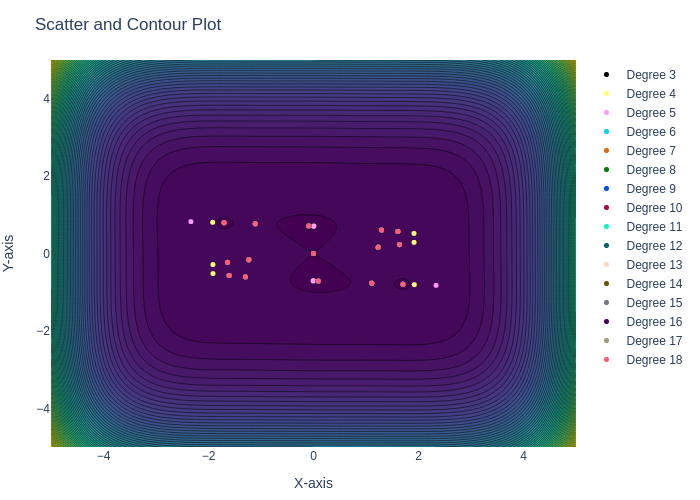

In [4]:
using PlotlyJS, Colors

# Generate the grid and evaluate the function
N = 150  # resolution of the grid
x = range(-C, C, length=N)
y = range(-C, C, length=N)
z = [f([xi, yi]) for yi in y, xi in x]
# Generate a color palette based on the number of unique `col` values
unique_cols = unique(df.col)
num_colors = length(unique_cols)
color_palette = distinguishable_colors(num_colors)
# Map the `col` values to the corresponding colors
col_to_color = Dict(unique_cols .=> color_palette)
# Create individual scatter traces for each unique `col` value
scatter_traces = [scatter(x=df[df.col .== c, :x], y=df[df.col .== c, :y], mode="markers", marker=attr(color=col_to_color[c], size=5), name="Degree $c") for c in unique_cols]
# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=80, colorscale="Viridis", showscale=false)
# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]
# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem")
)
# Display the combined plot with legend
display(plot(all_traces, layout))

Doesn't make too much sense, but maybe we could plot the level sets of the polynomial approximants

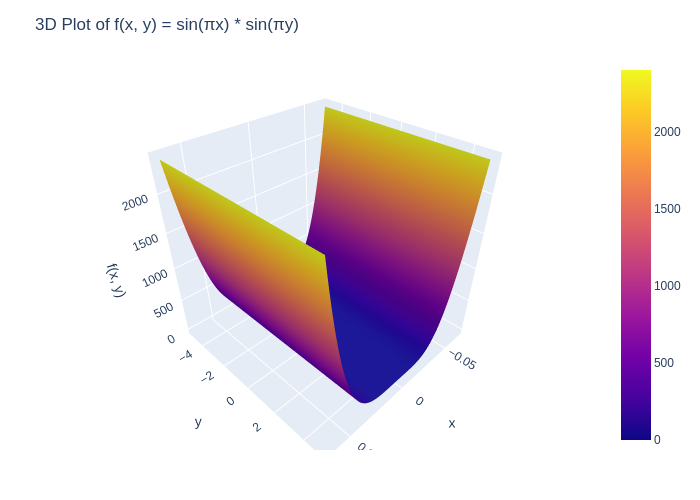

In [17]:
# plot on subdomain 
SmC = 0.5 * C
x = range(-1/15, 1/15, length=N)
y = range(-5, 5, length=N)
# Generate the grid and evaluate the function
zi = [f([xi, yi]) for yi in y, xi in x]
# Create the plot
sf = surface(x=x, y=y, z=zi)
# Layout for the plot
layout = Layout(title="3D Plot of f(x, y) = sin(πx) * sin(πy)",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"
    ))
# Display the plot
plot(sf, layout)

Initialize Zeroth order optimization method at each of the critical points of the approximants. 

In [15]:
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)

    distance = norm(x0 - minimizer)

    df.local_minima[i] = min_value
    df.distance_to_minima[i] = distance
    df.steps[i] = steps
    df.converged[i] = converged

    println("Initial point: ", x0)
    println("Minimizer: ", minimizer)
    println("Distance to minima: ", distance)
    println("Number of steps: ", steps)
    println("Converged: ", converged)
    println(summary(res))
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0    -1.066401e-32     3.964935e-15
 * time: 1.5020370483398438e-5
Initial point: [-4.891137019516415e-16, 4.344777967323897e-16]
Minimizer: [-4.891137019516415e-16, 4.344777967323897e-16]
Distance to minima: 0.0
Number of steps: 0
Converged: true
L-BFGS
Optimizing for point 2
Iter     Function value   Gradient norm 
     0     1.059068e+01     4.966758e+01
 * time: 1.3113021850585938e-5
     1     1.724556e+00     1.472257e+01
 * time: 0.0001270771026611328
     2     3.557290e-03     1.912120e+00
 * time: 0.000247955322265625
     3    -1.966224e-01     7.168339e-01
 * time: 0.00032210350036621094
     4    -2.149436e-01     1.380633e-01
 * time: 0.0003941059112548828
     5    -2.154616e-01     9.980460e-03
 * time: 0.0004661083221435547
     6    -2.154638e-01     6.377978e-05
 * time: 0.0005359649658203125
     7    -2.154638e-01     2.594298e-08
 * time: 0.0006051063537597656
     8    -2.154638e-01     2.905748

In [23]:
filtered_df = df[df.col.==7, :]


15×8 DataFrame
 Row │ x             y             col    result        local_minima  distance ⋯
     │ Float64       Float64       Int64  Float64       Float64       Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.6071        0.568651         7   2.10425       2.10425               ⋯
   2 │  0.089842     -0.712656         7  -1.03163      -1.03163
   3 │  1.23023       0.162335         7   2.4963        2.4963
   4 │ -0.089842      0.712656         7  -1.03163      -1.03163
   5 │  1.10921      -0.768268         7   0.543719      0.543719              ⋯
   6 │ -1.23023      -0.162335         7   2.4963        2.4963
   7 │ -2.25967e-14   1.38165e-14      7   9.66662e-28   9.66662e-28
   8 │ -1.10921       0.768268         7   0.543719      0.543719
   9 │ -1.29607      -0.605084         7   2.22947       2.22947               ⋯
  10 │ -1.6071       -0.568651         7   2.10425       2.10425
  11 │  1.29607       0.605084         7   2.22947       2.22947
  12 │  1.70361      -0.796084         7  -0.215464     -0.215464
  13 │  1.63807       0.228674         7   2.22936       2.22936               ⋯
  14 │ -1.70361       0.796084         7  -0.215464     -0.215464
  15 │ -1.63807      -0.228674         7   2.22936       2.22936
                                                               3 columns omitted